In [101]:
# 📊 Set global plotting style and create figures directory
# Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Create figures folder
os.makedirs("figures", exist_ok=True)

# Folder path
data_path = "ELAD_Data"

In [102]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load the Datasets

In [103]:
# 📥 Load environmental data from CSV files
# Load environmental data
weather = pd.read_csv(os.path.join(data_path, "weather.csv"))
carbon = pd.read_csv(os.path.join(data_path, "carbon_intensity.csv"))
env_data = pd.concat([weather, carbon], axis=1)

# Load all building data
buildings = []
building_names = []
for i in range(1, 18):  # Building_1 to Building_17
    file_name = f"Building_{i}.csv"
    full_path = os.path.join(data_path, file_name)
    df = pd.read_csv(full_path)
    df_full = pd.concat([df, env_data.copy()], axis=1)
    buildings.append(df_full)
    building_names.append(f"Building_{i}")

### Analysis

In [ ]:
###### OLD VERSION!!!!!

# 1.) Check for NaN Values
check_nans(buildings, building_names)

# 2.) Check for Outliers (IQR)
for df, name in zip(buildings, building_names):
    outlier_counts = detect_outliers(df)
    print(f"Outliers in {name}:\n", outlier_counts, "\n")

# 3.) Plot the stuff / Also Heatmaps
for df, name in zip(buildings, building_names):
    plot_heatmap(df, name)
    plot_each_column(df, name)

In [104]:
# NEW VERSION!!!!!
# With Cleaning etc.

dhw_means = []
features_for_distance = []

for i in range(len(buildings)):
    name = building_names[i]
    print(f"\nProcessing {name}")

    df_clean = clean_and_impute(buildings[i])

    # Save preprocessed CSV
    df_clean.to_csv(f"Dataset_Preprocessed/{name}.csv", index=False)

    # Plots
    plot_heatmap(df_clean, name)
    plot_each_column(df_clean, name)

    # Store for clustering
    if 'non_shiftable_load' in df_clean.columns:
        dhw_means.append(df_clean['non_shiftable_load'].mean())
    else:
        dhw_means.append(0)  # or np.nan if preferred

    features_for_distance.append(df_clean.mean(numeric_only=True))


Processing Building_1

Processing Building_2

Processing Building_3

Processing Building_4

Processing Building_5

Processing Building_6

Processing Building_7

Processing Building_8

Processing Building_9

Processing Building_10

Processing Building_11

Processing Building_12

Processing Building_13

Processing Building_14

Processing Building_15

Processing Building_16

Processing Building_17


#### CLUSTERING

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Format labels nicely
pretty_names = [name.replace("_", " ") for name in building_names]

# --- Clustering ---
plt.figure(figsize=(14, 8))
linked = linkage(np.array(non_shiftable_means).reshape(-1, 1), method='ward')

# Dendrogram with clean labels
ddata = dendrogram(
    linked,
    labels=pretty_names,
    orientation='top',
    color_threshold=0.6
)

# Thicken colored lines
ax = plt.gca()
for collection in ax.collections:
    collection.set_linewidth(4)

plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)

plt.tight_layout()
plt.savefig("figures/Clustering/hierarchical/Hierarical_Clustering.png")
plt.close()

In [116]:
building_names

['Building_1',
 'Building_2',
 'Building_3',
 'Building_4',
 'Building_5',
 'Building_6',
 'Building_7',
 'Building_8',
 'Building_9',
 'Building_10',
 'Building_11',
 'Building_12',
 'Building_13',
 'Building_14',
 'Building_15',
 'Building_16',
 'Building_17']

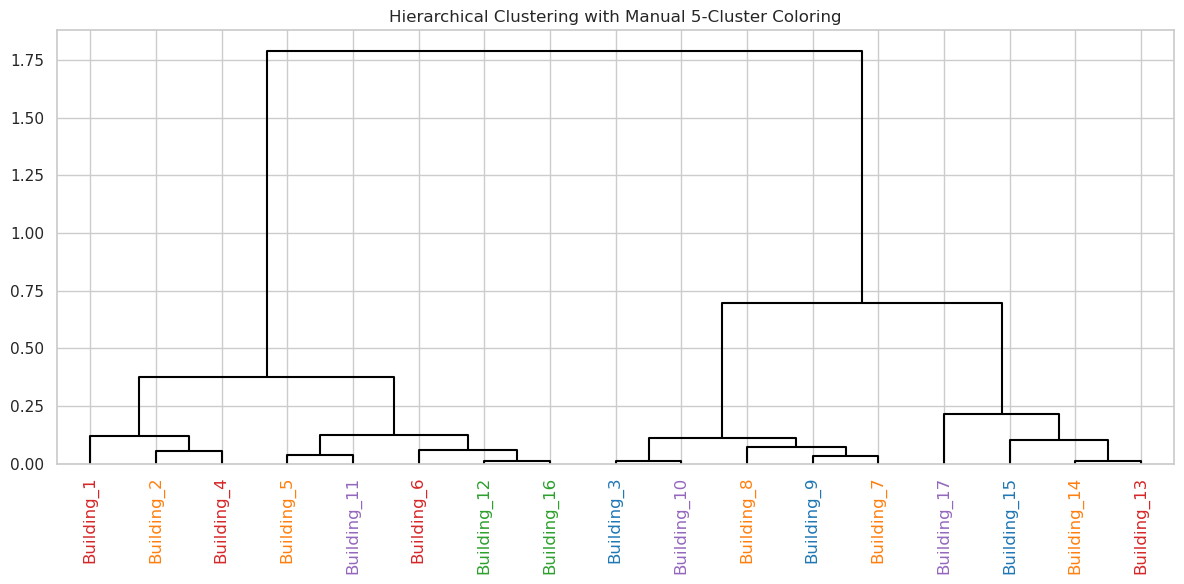

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import set_link_color_palette
from matplotlib.colors import to_hex, ListedColormap

# --- 1. Building order & dummy distances ---
building_names = [
    'Building_15', 'Building_3', 'Building_9',
    'Building_7', 'Building_14', 'Building_2', 'Building_5', 'Building_8',
    'Building_12', 'Building_16',
    'Building_4', 'Building_13', 'Building_1', 'Building_6',
    'Building_17', 'Building_10', 'Building_11'
]
# Example data: Replace with your real non_shiftable_means!
non_shiftable_means = np.random.rand(len(building_names))
linked = linkage(non_shiftable_means.reshape(-1, 1), method='ward')

# --- 2. Manual cluster assignment ---
custom_clusters = {
    1: ['Building_15', 'Building_3', 'Building_9'],
    2: ['Building_7', 'Building_14', 'Building_2', 'Building_5', 'Building_8'],
    3: ['Building_12', 'Building_16'],
    4: ['Building_4', 'Building_13', 'Building_1', 'Building_6'],
    5: ['Building_17', 'Building_10', 'Building_11']
}

# Map buildings to cluster IDs
cluster_map = {}
for cid, buildings in custom_clusters.items():
    for b in buildings:
        cluster_map[b] = cid

# Assign consistent colors to clusters
colors = plt.cm.tab10.colors  # color palette
cluster_colors = {cid: to_hex(colors[i % 10]) for i, cid in enumerate(custom_clusters)}
label_colors = [cluster_colors[cluster_map[b]] for b in building_names]

# --- 3. Color function for branches ---
def color_func(node_id):
    if node_id < len(building_names):  # original leaf
        bname = building_names[node_id]
        return cluster_colors[cluster_map[bname]]
    return "#000000"  # default for merges between clusters

# --- 4. Plot dendrogram ---
plt.figure(figsize=(12, 6))
dend = dendrogram(
    linked,
    labels=building_names,
    orientation='top',
    link_color_func=color_func,
    color_threshold=0  # force custom coloring
)

# Color and rotate x-axis labels
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for lbl in x_labels:
    bname = lbl.get_text()
    lbl.set_color(cluster_colors[cluster_map[bname]])
    lbl.set_rotation(90)

plt.title("Hierarchical Clustering with Manual 5-Cluster Coloring")
plt.tight_layout()
plt.show()

# Clustering Results:

#### Cluster 1: 15, 3, 9
#### Cluster 2: 7, 14, 2, 5, 8
#### Cluster 3: 12, 16
#### Cluster 4: 4, 13, 1, 6
#### Cluster 5: 17, 10, 11

In [ ]:
def construct_datetime(df):
    df['hour'] = df['hour'].replace(24, 0)
    df['day'] = (df.index // 24) + 1
    df['year'] = 2022
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    df.drop(columns=['year'], inplace=True)
    return df

### XGBOOST 

#### 24h Ahead

In [ ]:
# 📥 Load environmental data from CSV files
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configuration
data_path = "Dataset_Preprocessed"
building_files = sorted([f for f in os.listdir(data_path) if f.startswith("Building_")])
forecast_horizon = 24
target_col = 'non_shiftable_load'

# Create output directories
os.makedirs("figures", exist_ok=True)
os.makedirs("models/xgboost", exist_ok=True)

# Expanded hyperparameter grid for thorough HPO
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Function to add lag and rolling window features
def add_lag_and_rolling_features(df, target_col='non_shiftable_load', lags=[1, 2, 3, 6, 12, 24], roll_windows=[6, 12, 24]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    for window in roll_windows:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()
    return df

# Function to construct datetime from month, hour, and day_type
def construct_datetime(df):
    # Replace hour 24 with 0 and adjust day_type accordingly
    df['hour'] = df['hour'].replace(24, 0)
    df['day_type'] = np.where(df['hour'] == 0, df['day_type'] + 1, df['day_type'])
    df['day_type'] = df['day_type'].replace(8, 1)  # Wrap around to Monday if day_type was Sunday

    # Assume the data starts from the first day of the month
    df['day'] = (df.index // 24) + 1

    # Construct datetime
    df['year'] = 2022
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    df.drop(columns=['year'], inplace=True)
    return df

# Initialize results list
results = []

# Process each building file
for file in building_files:
    df = pd.read_csv(os.path.join(data_path, file))

    if target_col not in df.columns:
        print(f"⚠️ Skipping {file} — no target column '{target_col}'.")
        continue

    # Construct accurate datetime
    df = construct_datetime(df)

    # Feature engineering
    df = add_lag_and_rolling_features(df, target_col=target_col)

    # Shift target for forecasting
    df['target'] = df[target_col].shift(-forecast_horizon)
    df.dropna(inplace=True)

    # Define feature columns
    feature_cols = [col for col in df.columns if col not in [target_col, 'target', 'datetime', 'month', 'day', 'hour', 'day_type']]

    # Prepare input and output data
    X = df[feature_cols].values
    y = df['target'].values

    # Time-based train-test split
    split_idx = int(len(X) * 0.7)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    time_test = df[['datetime', 'month', 'day', 'hour']].iloc[split_idx:]

    # Hyperparameter optimization and model training
    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
    grid.fit(X_train, y_train)

    # Retrieve the best model
    best_model = grid.best_estimator_

    # Save the trained model
    model_filename = f"models/xgboost/{file.replace('.csv', '')}_xgb_model.pkl"
    joblib.dump(best_model, model_filename)

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Evaluate model performance
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    # Store results
    results.append({
        "Building": file.replace(".csv", ""),
        "Best_Params": grid.best_params_,
        "RMSE_24h": rmse,
        "MAE_24h": mae
    })

    print(f"✅ {file}: RMSE={rmse:.2f}, MAE={mae:.2f}")

    # Save detailed predictions
    pred_df = time_test.copy()
    pred_df["true_value"] = y_test
    pred_df["predicted_value"] = y_pred
    pred_df.to_csv(f"figures/{file.replace('.csv','')}_predictions_detailed.csv", index=False)

    # Save average prediction per hour
    avg_df = pred_df.groupby('hour')[['true_value', 'predicted_value']].mean().reset_index()
    avg_df.to_csv(f"figures/{file.replace('.csv','')}_avg_hourly_predictions.csv", index=False)

# Save overall results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("figures/xgboost_24h_sliding_window_results.csv", index=False)
print("📁 Results saved to: figures/xgboost_24h_sliding_window_results.csv")
print("💾 Models saved to: models/xgboost/")

#### LSTM

In [ ]:
# 📥 Load environmental data from CSV files
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import joblib

os.makedirs("models/lstm", exist_ok=True)
os.makedirs("figures", exist_ok=True)
lstm_results = []

def create_lstm_sequences(df, feature_cols, target_col='non_shiftable_load', window_size=24, forecast_horizon=24):
    X, y, meta = [], [], []
    for i in range(window_size, len(df) - forecast_horizon):
        x_seq = df[feature_cols].iloc[i - window_size:i].values
        target = df[target_col].iloc[i + forecast_horizon]
        ts = df.iloc[i + forecast_horizon][['datetime', 'month', 'day', 'hour']]
        X.append(x_seq)
        y.append(target)
        meta.append(ts)
    return np.array(X), np.array(y), pd.DataFrame(meta)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

for file in building_files:
    df = pd.read_csv(os.path.join(data_path, file))
    if target_col not in df.columns:
        continue

    df = construct_datetime(df)
    df = add_lag_and_rolling_features(df, target_col=target_col)
    df.dropna(inplace=True)

    feature_cols = [col for col in df.columns if col not in ['datetime', 'month', 'day', 'hour', target_col]]
    scaler = StandardScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    X, y, meta = create_lstm_sequences(df, feature_cols, target_col, 24, forecast_horizon)
    split_idx = int(len(X) * 0.7)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    meta_test = meta.iloc[split_idx:].reset_index(drop=True)

    model = build_lstm_model(X_train.shape[1:])
    model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32,
              callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=0)

    model.save(f"models/lstm/{file.replace('.csv','')}_lstm_model.h5")

    y_pred = model.predict(X_test).flatten()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    lstm_results.append({
        "Building": file.replace(".csv", ""),
        "RMSE_24h": rmse,
        "MAE_24h": mae
    })

    pred_df = meta_test.copy()
    pred_df["true_value"] = y_test
    pred_df["predicted_value"] = y_pred
    pred_df.to_csv(f"figures/{file.replace('.csv','')}_LSTM_predictions_detailed.csv", index=False)

    avg_df = pred_df.groupby('hour')[['true_value', 'predicted_value']].mean().reset_index()
    avg_df.to_csv(f"figures/{file.replace('.csv','')}_LSTM_avg_hourly_predictions.csv", index=False)

pd.DataFrame(lstm_results).to_csv("figures/lstm_24h_results.csv", index=False)

### Random Forest

In [ ]:
# 📥 Load environmental data from CSV files
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

os.makedirs("models/random_forest", exist_ok=True)
rf_results = []

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

for file in building_files:
    df = pd.read_csv(os.path.join(data_path, file))
    if target_col not in df.columns:
        continue

    df = construct_datetime(df)
    df = add_lag_and_rolling_features(df, target_col=target_col)
    df['target'] = df[target_col].shift(-forecast_horizon)
    df['datetime_shifted'] = df['datetime'].shift(-forecast_horizon)
    df['month_shifted'] = df['month'].shift(-forecast_horizon)
    df['day_shifted'] = df['day'].shift(-forecast_horizon)
    df['hour_shifted'] = df['hour'].shift(-forecast_horizon)
    df.dropna(inplace=True)

    time_meta = df[['datetime_shifted', 'month_shifted', 'day_shifted', 'hour_shifted']].reset_index(drop=True)
    time_meta.columns = ['datetime', 'month', 'day', 'hour']

    feature_cols = [col for col in df.columns if col not in [
        target_col, 'target', 'datetime', 'datetime_shifted',
        'month', 'month_shifted', 'day', 'day_shifted', 'hour', 'hour_shifted'
    ]]
    X = df[feature_cols].values
    y = df['target'].values

    split_idx = int(len(X) * 0.7)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    time_test = time_meta.iloc[split_idx:]

    rf = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error', verbose=0)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    joblib.dump(best_model, f"models/random_forest/{file.replace('.csv','')}_rf_model.pkl")

    y_pred = best_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    rf_results.append({
        "Building": file.replace(".csv", ""),
        "Best_Params": grid.best_params_,
        "RMSE_24h": rmse,
        "MAE_24h": mae
    })

    pred_df = time_test.copy()
    pred_df["true_value"] = y_test
    pred_df["predicted_value"] = y_pred
    pred_df.to_csv(f"figures/{file.replace('.csv','')}_RF_predictions_detailed.csv", index=False)

    avg_df = pred_df.groupby('hour')[['true_value', 'predicted_value']].mean().reset_index()
    avg_df.to_csv(f"figures/{file.replace('.csv','')}_RF_avg_hourly_predictions.csv", index=False)

pd.DataFrame(rf_results).to_csv("figures/random_forest_24h_results.csv", index=False)

## TL Testing per Cluster


### XGBoost

In [ ]:
# 📥 Load environmental data from CSV files
import os
import pandas as pd
import numpy as np
import joblib

# Same config as training
data_path = "Dataset_Preprocessed"
model_path = "models/xgboost"
forecast_horizon = 24
target_col = 'non_shiftable_load'

# Use same lag/rolling config as before
def add_lag_and_rolling_features(df, target_col, lags=[1, 2, 3, 6, 12, 24], roll_windows=[6, 12, 24]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    for window in roll_windows:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()
    return df

def construct_datetime(df):
    df['hour'] = df['hour'].replace(24, 0)
    df['day'] = (df.index // 24) + 1
    df['year'] = 2022
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    df.drop(columns=['year'], inplace=True)
    return df

# Process each model/dataset
for filename in os.listdir(model_path):
    if not filename.endswith("_xgb_model.pkl"):
        continue

    building = filename.replace("_xgb_model.pkl", "")
    file_path = os.path.join(data_path, f"{building}.csv")
    if not os.path.exists(file_path):
        print(f"⚠️ Dataset missing for {building}, skipping.")
        continue

    df = pd.read_csv(file_path)
    df = construct_datetime(df)
    df = add_lag_and_rolling_features(df, target_col=target_col)
    df['target'] = df[target_col].shift(-forecast_horizon)
    df.dropna(inplace=True)

    feature_cols = [col for col in df.columns if col not in [target_col, 'target', 'datetime', 'month', 'day', 'hour', 'day_type']]

    # Save feature list
    feature_out = os.path.join(model_path, f"{building}_xgb_model_features.pkl")
    joblib.dump(feature_cols, feature_out)
    print(f"✅ Saved features for {building}")

In [ ]:
# 📥 Load environmental data from CSV files
import os
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- CONFIG ---
data_path = "Dataset_Preprocessed"
results_path = "transfer_learning"
original_results_path = "figures/xgboost_24h_sliding_window_results.csv"
model_base_path = "models/xgboost"
target_col = 'non_shiftable_load'
forecast_horizon = 24
timeframes = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70,
               77, 84, 91, 98, 105, 112, 119, 126, 133, 140,
               147, 154, 161, 168, 175, 182, 189, 196, 203, 210,
               217, 224, 231, 238, 240]

clusters = {
    1: [15, 3, 9],
    2: [7, 14, 2, 5, 8],
    3: [12, 16],
    4: [4, 13, 1, 6],
    5: [17, 10, 11]
}

os.makedirs(results_path, exist_ok=True)

def add_lag_and_rolling_features(df, target_col, lags=[1, 2, 3, 6, 12, 24], roll_windows=[6, 12, 24]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    for window in roll_windows:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()
    return df

def construct_datetime(df):
    df['hour'] = df['hour'].replace(24, 0)
    df['day'] = (df.index // 24) + 1
    df['year'] = 2022
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    df.drop(columns=['year'], inplace=True)
    return df

for cluster_id, buildings in clusters.items():
    print(f"\n🔁 Cluster {cluster_id}")
    cluster_dir = os.path.join(results_path, f"cluster_{cluster_id}")
    os.makedirs(cluster_dir, exist_ok=True)

    # --- Load best model ---
    perf_df = pd.read_csv(original_results_path)
    best_row = perf_df[perf_df["Building"].isin([f"Building_{b}" for b in buildings])].loc[lambda x: x["RMSE_24h"].idxmin()]
    source_building = best_row["Building"]
    best_building_id = int(source_building.split("_")[1])

    print(f"🏆 Best model: {source_building}")
    with open(os.path.join(cluster_dir, "best_source_building.txt"), "w") as f:
        f.write(f"Best: {source_building}\n")
        f.write(f"RMSE: {best_row['RMSE_24h']:.3f}, MAE: {best_row['MAE_24h']:.3f}")

    model_path = os.path.join(model_base_path, f"{source_building}_xgb_model.pkl")
    feature_path = model_path.replace(".pkl", "_features.pkl")
    base_model = joblib.load(model_path)
    feature_cols = joblib.load(feature_path)

    results = []

    for target_id in buildings:
        if target_id == best_building_id:
            continue

        print(f"🔁 Transfer to Building_{target_id}")
        df = pd.read_csv(os.path.join(data_path, f"Building_{target_id}.csv"))
        df = construct_datetime(df)
        df = add_lag_and_rolling_features(df, target_col)
        df['target'] = df[target_col].shift(-forecast_horizon)
        df.dropna(inplace=True)

        # Load test timestamps
        original_pred_file = os.path.join("figures", f"Building_{target_id}_predictions_detailed.csv")
        if not os.path.exists(original_pred_file):
            print(f"⚠️ Missing {original_pred_file}, skipping.")
            continue
        original_times = pd.to_datetime(pd.read_csv(original_pred_file)["datetime"])

        for days in timeframes:
            df_sub = df[df['datetime'] <= df['datetime'].min() + pd.Timedelta(days=days)].copy()
            if len(df_sub) < 50:
                print(f"⚠️ Not enough training data for {days} days")
                continue

            try:
                df_sub = df_sub[feature_cols + ['datetime', 'month', 'day', 'hour', 'target']]
            except KeyError:
                print(f"⚠️ Feature mismatch in Building_{target_id}, skipping.")
                continue

            # Get same test timestamps as original
            test_df = df[df['datetime'].isin(original_times)].copy()
            train_df = df_sub.copy()

            if len(test_df) == 0 or len(train_df) < 50:
                print(f"⚠️ Skipping {target_id}, {days} days — not enough data")
                continue

            X_train = train_df[feature_cols].values
            y_train = train_df["target"].values
            X_test = test_df[feature_cols].values
            y_test = test_df["target"].values

            # ----- Transfer Learning -----
            model_tl = joblib.load(model_path)
            model_tl.fit(X_train, y_train, xgb_model=model_tl.get_booster())
            y_pred_tl = model_tl.predict(X_test)

            rmse_tl = mean_squared_error(y_test, y_pred_tl, squared=False)
            mae_tl = mean_absolute_error(y_test, y_pred_tl)

            # Save TL model
            joblib.dump(model_tl, os.path.join(cluster_dir, f"Building_{target_id}_tuned_{days}days.pkl"))

            pred_df = test_df[['datetime', 'month', 'day', 'hour']].copy().reset_index(drop=True)
            pred_df["true_value"] = y_test
            pred_df["predicted_value"] = y_pred_tl
            pred_df.to_csv(os.path.join(cluster_dir, f"Building_{target_id}_predictions_detailed_{days}days_TL.csv"), index=False)

            # ----- Baseline Model -----
            model_base = XGBRegressor(objective='reg:squarederror', random_state=42)
            model_base.fit(X_train, y_train)
            y_pred_base = model_base.predict(X_test)

            rmse_base = mean_squared_error(y_test, y_pred_base, squared=False)
            mae_base = mean_absolute_error(y_test, y_pred_base)

            # Save baseline model
            joblib.dump(model_base, os.path.join(cluster_dir, f"Building_{target_id}_baseline_{days}days.pkl"))

            pred_base = test_df[['datetime', 'month', 'day', 'hour']].copy().reset_index(drop=True)
            pred_base["true_value"] = y_test
            pred_base["predicted_value"] = y_pred_base
            pred_base.to_csv(os.path.join(cluster_dir, f"Building_{target_id}_predictions_detailed_{days}days_BASE.csv"), index=False)

            # Save combined metrics
            results.append({
                "Cluster": cluster_id,
                "Source": source_building,
                "Target": f"Building_{target_id}",
                "Days": days,
                "RMSE_TL": rmse_tl,
                "MAE_TL": mae_tl,
                "RMSE_BASE": rmse_base,
                "MAE_BASE": mae_base
            })

    pd.DataFrame(results).to_csv(os.path.join(cluster_dir, "results.csv"), index=False)

### LSTM

In [ ]:
!pip install numpy pandas scikit-learn tensorflow

In [ ]:
# 📥 Load environmental data from CSV files
import os
import numpy as np
import pandas as pd
from keras.models import load_model, Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- CONFIG ---
data_path = "Dataset_Preprocessed"
results_path = "transfer_learning_lstm"
model_path_base = "models/lstm"
predictions_base = "figures"
forecast_horizon = 24
window_size = 24
target_col = 'non_shiftable_load'
timeframes = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70,
               77, 84, 91, 98, 105, 112, 119, 126, 133, 140,
               147, 154, 161, 168, 175, 182, 189, 196, 203, 210,
               217, 224, 231, 238, 240]

clusters = {
    1: [15, 3, 9],
    2: [7, 14, 2, 5, 8],
    3: [12, 16],
    4: [4, 13, 1, 6],
    5: [17, 10, 11]
}

os.makedirs(results_path, exist_ok=True)

# --- Feature + datetime helper ---
def construct_datetime(df):
    df['hour'] = df['hour'].replace(24, 0)
    df['day'] = (df.index // 24) + 1
    df['year'] = 2022
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    df.drop(columns=['year'], inplace=True)
    return df

def add_lag_and_rolling_features(df, target_col='non_shiftable_load', lags=[1,2,3,6,12,24], roll_windows=[6,12,24]):
    df = df.copy()
    for lag in lags:
        df[f"{target_col}_lag_{lag}"] = df[target_col].shift(lag)
    for win in roll_windows:
        df[f"{target_col}_roll_mean_{win}"] = df[target_col].rolling(win).mean()
        df[f"{target_col}_roll_std_{win}"] = df[target_col].rolling(win).std()
    return df

def create_lstm_sequences(df, feature_cols, window_size=24, forecast_horizon=24):
    X, y, meta = [], [], []
    for i in range(window_size, len(df) - forecast_horizon):
        x_seq = df[feature_cols].iloc[i - window_size:i].values
        target = df[target_col].iloc[i + forecast_horizon]
        ts = df.iloc[i + forecast_horizon][['datetime', 'month', 'day', 'hour']]
        X.append(x_seq)
        y.append(target)
        meta.append(ts)
    return np.array(X), np.array(y), pd.DataFrame(meta)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

b_buildings = ['Building_15','Building_5','Building_12','Building_6','Building_11']
i = 0
# --- MAIN TL LOOP ---
for cluster_id, buildings in clusters.items():
    cluster_dir = os.path.join(results_path, f"cluster_{cluster_id}")
    os.makedirs(cluster_dir, exist_ok=True)

    # Identify best source model from prior results
    perf_df = pd.read_csv("figures/lstm_24h_results.csv")
    best_row = perf_df[perf_df["Building"].isin([f"Building_{b}" for b in buildings])].loc[lambda x: x["RMSE_24h"].idxmin()]
    source_building = b_buildings[i]  #best_row["Building"] # Building_1
    i = i + 1
    source_model_path = f"{model_path_base}/{source_building}_lstm_model.h5"
    best_building_id = int(source_building.split("_")[1])

    print(f"📦 Cluster {cluster_id}: Using {source_building} as source")

    with open(os.path.join(cluster_dir, "best_source_building.txt"), "w") as f:
        f.write(f"Best: {source_building}\nRMSE: {best_row['RMSE_24h']:.3f}, MAE: {best_row['MAE_24h']:.3f}")

    results = []

    for target_id in buildings:
        if target_id == best_building_id:
            continue

        target_file = f"Building_{target_id}.csv"
        df = pd.read_csv(os.path.join(data_path, target_file))
        df = construct_datetime(df)
        df = add_lag_and_rolling_features(df, target_col)
        df.dropna(inplace=True)

        feature_cols = [col for col in df.columns if col not in ['datetime', 'month', 'day', 'hour', target_col, 'target']]
        scaler = StandardScaler()
        df[feature_cols] = scaler.fit_transform(df[feature_cols])

        # Get original test timestamps
        pred_file = f"{predictions_base}/Building_{target_id}_LSTM_predictions_detailed.csv"
        test_times = pd.read_csv(pred_file)["datetime"]
        test_times = pd.to_datetime(test_times)

        for days in timeframes:
            df_sub = df[df['datetime'] <= df['datetime'].min() + pd.Timedelta(days=days)].copy()
            if len(df_sub) < 100:
                continue

            X_all, y_all, meta_all = create_lstm_sequences(df_sub, feature_cols, window_size, forecast_horizon)
            df_test_full = df[df["datetime"].isin(test_times)]
            X_test, y_test, meta_test = create_lstm_sequences(df_test_full, feature_cols, window_size, forecast_horizon)

            # --- Transfer Learning ---
            model_tl = load_model(source_model_path, compile=False)
            model_tl.compile(loss='mae', optimizer='adam')
            model_tl.fit(X_all, y_all, epochs=10, batch_size=32, verbose=0)
            y_pred_tl = model_tl.predict(X_test).flatten()
            rmse_tl = mean_squared_error(y_test, y_pred_tl, squared=False)
            mae_tl = mean_absolute_error(y_test, y_pred_tl)

            # --- Reference Model ---
            model_ref = build_lstm_model(X_all.shape[1:])
            model_ref.fit(X_all, y_all, epochs=30, batch_size=32, verbose=0)
            y_pred_base = model_ref.predict(X_test).flatten()
            rmse_base = mean_squared_error(y_test, y_pred_base, squared=False)
            mae_base = mean_absolute_error(y_test, y_pred_base)

            # Save predictions
            meta_test["true_value"] = y_test
            meta_test["predicted_value_tl"] = y_pred_tl
            meta_test["predicted_value_base"] = y_pred_base
            meta_test.to_csv(os.path.join(cluster_dir, f"Building_{target_id}_predictions_{days}days.csv"), index=False)

            # Save models
            model_tl.save(os.path.join(cluster_dir, f"Building_{target_id}_tl_{days}days.h5"))
            model_ref.save(os.path.join(cluster_dir, f"Building_{target_id}_base_{days}days.h5"))

            results.append({
                "Cluster": cluster_id,
                "Source": source_building,
                "Target": f"Building_{target_id}",
                "Days": days,
                "RMSE_TL": rmse_tl,
                "MAE_TL": mae_tl,
                "RMSE_BASE": rmse_base,
                "MAE_BASE": mae_base
            })

    pd.DataFrame(results).to_csv(os.path.join(cluster_dir, "results.csv"), index=False)

📦 Cluster 1: Using Building_15 as source
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


📦 Cluster 2: Using Building_5 as source
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 529ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Random Forest

In [ ]:
!pip install numpy pandas scikit-learn

In [ ]:
# 📥 Load environmental data from CSV files
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# CONFIG
data_path = "Dataset_Preprocessed"
model_path_base = "models/random_forest"
results_path = "transfer_learning_random_forest"
forecast_horizon = 24
target_col = 'non_shiftable_load'
timeframes = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70,
               77, 84, 91, 98, 105, 112, 119, 126, 133, 140,
               147, 154, 161, 168, 175, 182, 189, 196, 203, 210,
               217, 224, 231, 238, 240]

clusters = {
    1: [15, 3, 9],
    2: [7, 14, 2, 5, 8],
    3: [12, 16],
    4: [4, 13, 1, 6],
    5: [17, 10, 11]
}

os.makedirs(results_path, exist_ok=True)

def construct_datetime(df):
    df['hour'] = df['hour'].replace(24, 0)
    df['day'] = (df.index // 24) + 1
    df['year'] = 2022
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    df.drop(columns=['year'], inplace=True)
    return df

def add_lag_and_rolling_features(df, target_col, lags=[1, 2, 3, 6, 12, 24], roll_windows=[6, 12, 24]):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    for window in roll_windows:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()
    return df

for cluster_id, buildings in clusters.items():
    cluster_dir = os.path.join(results_path, f"cluster_{cluster_id}")
    os.makedirs(cluster_dir, exist_ok=True)

    # Identify best model from figures
    perf_df = pd.read_csv("figures/random_forest_24h_results.csv")
    best_row = perf_df[perf_df["Building"].isin([f"Building_{b}" for b in buildings])].loc[lambda x: x["RMSE_24h"].idxmin()]
    source_building = best_row["Building"]
    best_building_id = int(source_building.split("_")[1])

    with open(os.path.join(cluster_dir, "best_source_building.txt"), "w") as f:
        f.write(f"Best: {source_building}\n")
        f.write(f"RMSE: {best_row['RMSE_24h']:.3f}, MAE: {best_row['MAE_24h']:.3f}")

    results = []

    for target_id in buildings:
        if target_id == best_building_id:
            continue

        target_file = f"Building_{target_id}.csv"
        df = pd.read_csv(os.path.join(data_path, target_file))
        df = construct_datetime(df)
        df = add_lag_and_rolling_features(df, target_col)
        df['target'] = df[target_col].shift(-forecast_horizon)
        df.dropna(inplace=True)

        feature_cols = [col for col in df.columns if col not in ['datetime', 'month', 'day', 'hour', 'target', target_col]]

        # Load test timestamps from full prediction
        pred_file = f"figures/Building_{target_id}_RF_predictions_detailed.csv"
        if not os.path.exists(pred_file):
            print(f"⚠️ Missing {pred_file}, skipping {target_file}")
            continue
        test_times = pd.to_datetime(pd.read_csv(pred_file)["datetime"])

        for days in timeframes:
            df_train = df[df['datetime'] <= df['datetime'].min() + pd.Timedelta(days=days)].copy()
            df_test = df[df["datetime"].isin(test_times)].copy()

            if len(df_train) < 50 or len(df_test) < 10:
                continue

            X_train = df_train[feature_cols].values
            y_train = df_train['target'].values
            X_test = df_test[feature_cols].values
            y_test = df_test['target'].values

            # --- Transfer Learning ---
            rf_tl = joblib.load(f"{model_path_base}/{source_building}_rf_model.pkl")
            rf_tl.fit(X_train, y_train)
            y_pred_tl = rf_tl.predict(X_test)
            rmse_tl = mean_squared_error(y_test, y_pred_tl, squared=False)
            mae_tl = mean_absolute_error(y_test, y_pred_tl)

            joblib.dump(rf_tl, os.path.join(cluster_dir, f"Building_{target_id}_rf_model_{days}days_TL.pkl"))

            pred_df_tl = df_test[['datetime', 'month', 'day', 'hour']].copy().reset_index(drop=True)
            pred_df_tl["true_value"] = y_test
            pred_df_tl["predicted_value"] = y_pred_tl
            pred_df_tl.to_csv(os.path.join(cluster_dir, f"Building_{target_id}_predictions_detailed_{days}days_TL.csv"), index=False)

            # --- Reference Model ---
            rf_base = RandomForestRegressor(random_state=42)
            rf_base.fit(X_train, y_train)
            y_pred_base = rf_base.predict(X_test)
            rmse_base = mean_squared_error(y_test, y_pred_base, squared=False)
            mae_base = mean_absolute_error(y_test, y_pred_base)

            joblib.dump(rf_base, os.path.join(cluster_dir, f"Building_{target_id}_rf_model_{days}days_BASE.pkl"))

            pred_df_base = df_test[['datetime', 'month', 'day', 'hour']].copy().reset_index(drop=True)
            pred_df_base["true_value"] = y_test
            pred_df_base["predicted_value"] = y_pred_base
            pred_df_base.to_csv(os.path.join(cluster_dir, f"Building_{target_id}_predictions_detailed_{days}days_BASE.csv"), index=False)

            # Save results
            results.append({
                "Cluster": cluster_id,
                "Source": source_building,
                "Target": f"Building_{target_id}",
                "Days": days,
                "RMSE_TL": rmse_tl,
                "MAE_TL": mae_tl,
                "RMSE_BASE": rmse_base,
                "MAE_BASE": mae_base
            })

    pd.DataFrame(results).to_csv(os.path.join(cluster_dir, "results.csv"), index=False)

In [ ]:
# 📥 Load environmental data from CSV files
import os
import re
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MAPE helper
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

# Path to root folder with clusters
root_dir = "transfer_learning"

# Storage for metrics and raw values
metrics = []
raw_rows = []

# Walk through clusters
for cluster in sorted(os.listdir(root_dir)):
    cluster_path = os.path.join(root_dir, cluster)
    if not os.path.isdir(cluster_path):
        continue

    print(f"📁 Processing: {cluster}")

    for file in os.listdir(cluster_path):
        if file.endswith(".csv") and "predictions_detailed" in file:
            filepath = os.path.join(cluster_path, file)
            match = re.match(r"Building_(\d+)_predictions_detailed_(\d+)days\.csv", file)
            if not match:
                print(f"⚠️ Skipped: {file}")
                continue

            building_id = int(match.group(1))
            days = int(match.group(2))

            df = pd.read_csv(filepath)

            if 'true_value' not in df.columns or 'predicted_value' not in df.columns:
                print(f"⚠️ Missing columns in {file}")
                continue

            # Metrics
            y_true = df["true_value"]
            y_pred = df["predicted_value"]
            rmse = mean_squared_error(y_true, y_pred, squared=False)
            mae = mean_absolute_error(y_true, y_pred)
            mape = mean_absolute_percentage_error(y_true, y_pred)

            metrics.append({
                "Cluster": cluster,
                "Building": f"Building_{building_id}",
                "Days": days,
                "RMSE": rmse,
                "MAE": mae,
                "MAPE": mape
            })

            # Raw values
            for i, row in df.iterrows():
                raw_rows.append({
                    "Cluster": cluster,
                    "Building": f"Building_{building_id}",
                    "Days": days,
                    "Datetime": row.get("datetime", None),
                    "Hour": row.get("hour", None),
                    "True_Value": row["true_value"],
                    "Predicted_Value": row["predicted_value"]
                })

# ---- Export ----

if metrics:
    metrics_df = pd.DataFrame(metrics)
    try:
        metrics_df.sort_values(by=["Cluster", "Building", "Days"], inplace=True)
    except KeyError as e:
        print(f"❌ Sort error: {e}")
        print("🔍 Columns:", metrics_df.columns)

    metrics_df.to_csv("xgboost_metrics_summary.csv", index=False)
    print("✅ Saved: xgboost_metrics_summary.csv")
else:
    print("⚠️ No metrics collected!")

if raw_rows:
    raw_df = pd.DataFrame(raw_rows)
    raw_df.to_csv("xgboost_raw_predictions.csv", index=False)
    print("✅ Saved: xgboost_raw_predictions.csv")
else:
    print("⚠️ No raw prediction data collected!")

### Helper Functions

In [ ]:
# Function to check NaNs
def check_nans(dfs, names):
    for df, name in zip(dfs, names):
        print(f"NaN check for {name}:\n", df.isna().sum(), "\n")

# Function to detect outliers using IQR
def detect_outliers(df):
    outliers = {}
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers[col] = ((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)).sum()
    return outliers

# Function to plot heatmaps
def plot_heatmap(df, name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=False, fmt=".2f", cmap="coolwarm")
    plt.title(f"Correlation Heatmap - {name}")
    plt.tight_layout()
    plt.savefig(f"figures/ELAD22/Plots_After_Cleaning/Heatmaps/heatmap_{name}.png")
    plt.close()

# Function to plot each numeric column safely
def plot_each_column(df, name):
    for col in df.select_dtypes(include=[np.number]).columns:
        plt.figure()
        df[col].plot()
        plt.title(f"{col} - {name}")
        plt.xlabel("Timestep")
        plt.ylabel(col)
        plt.tight_layout()

        # Sanitize filename
        safe_col = re.sub(r'[^\w\-_. ]', '_', col).replace(" ", "_")
        filename = f"figures/ELAD22/Plots_After_Cleaning/Plots/{name}_{safe_col}.png"
        plt.savefig(filename)
        plt.close()

In [ ]:
def clean_and_impute(df, outlier_threshold=0.5, nan_threshold=0.5):
    df = df.copy()
    num_rows = len(df)

    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Step 1: Identify and count outliers
    outlier_flags = pd.DataFrame(False, index=df.index, columns=numeric_cols)
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
        outlier_flags[col] = outlier_mask

    # Step 2: Drop columns with too many NaNs or outliers
    columns_to_drop = []
    for col in numeric_cols:
        nan_ratio = df[col].isna().sum() / num_rows
        outlier_ratio = outlier_flags[col].sum() / num_rows
        if nan_ratio > nan_threshold or outlier_ratio > outlier_threshold:
            columns_to_drop.append(col)

    df.drop(columns=columns_to_drop, inplace=True)

    # Step 3: Impute remaining NaNs with forward fill + backward fill + median fallback
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isna().any():
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
            if df[col].isna().any():
                df[col].fillna(df[col].median(), inplace=True)

    return df